In [1]:
import numpy as np
import pandas as pd
import os
import random
import shutil

import cv2
import pydicom
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from ultralytics import YOLO
import wandb

np.random.seed(1337)


try:
    shutil.rmtree('/kaggle/working/')
except:
    pass


CSV_FILE = '../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
TRAIN_SRC_DIR = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/'
TEST_SRC_DIR = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images/'
DATASET_DIR = './datasets/'
TEST_IMG_DIR = 'test_images/'
annotations = pd.read_csv(CSV_FILE)
print(annotations.info())
annotations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB
None


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [2]:
positive_annotations = annotations[annotations.Target == 1]
negative_annotations = annotations[annotations.Target == 0]

print(positive_annotations['patientId'].drop_duplicates().shape[0])
print(negative_annotations['patientId'].drop_duplicates().shape[0])
print(negative_annotations['patientId'].shape[0])

negative_sample = negative_annotations.sample(600)
negative_sample['patientId'].shape[0]

annotations = pd.concat([positive_annotations, negative_sample])
print(annotations.shape)
annotations.head()

6012
20672
20672
(10155, 6)


,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [3]:
patient_id_series = annotations.patientId.drop_duplicates()
print('Number of images:', patient_id_series.size)

train_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=42)
print('Train set number:', len(train_series))
print('Validation set number:', len(val_series))

Number of images: 6612
Train set number: 5950
Validation set number: 662


In [4]:
for patient_id in tqdm(train_series):
    src_path = TRAIN_SRC_DIR + patient_id + '.dcm'
    dcm_data = pydicom.dcmread(src_path)
    image_array = dcm_data.pixel_array
    image = Image.fromarray(image_array)
    image.save(DATASET_DIR + 'images/train/' + patient_id + '.jpg')
print('Images moved to train folder:', len(os.listdir(DATASET_DIR + 'images/train/')))
    
for patient_id in tqdm(val_series):
    src_path = TRAIN_SRC_DIR + patient_id + '.dcm'
    dcm_data = pydicom.dcmread(src_path)
    image_array = dcm_data.pixel_array
    image = Image.fromarray(image_array)
    image.save(DATASET_DIR + 'images/val/' + patient_id + '.jpg')
print('Images moved to val folder:', len(os.listdir(DATASET_DIR + 'images/val/')))

100%|██████████| 5950/5950 [01:07<00:00, 88.43it/s]


Images moved to train folder: 5950


100%|██████████| 662/662 [00:07<00:00, 90.10it/s]

Images moved to val folder: 1653


In [5]:
def translate_bbox(bbox):
    img_size = 1024 # rsna defualt image size
    
    top_left_x = bbox[0]
    top_left_y = bbox[1]
    absolute_w = bbox[2]
    absolute_h = bbox[3]

    relative_w = absolute_w / img_size
    relative_h = absolute_h / img_size
    
    relative_x = top_left_x / img_size + relative_w / 2
    relative_y = top_left_y / img_size + relative_h / 2
    
    
    return relative_x, relative_y, relative_w, relative_h
    
def revert_bbox(rx, ry, rw, rh):
    img_size = 1024 # rsna defualt image size
    
    x = (rx-rw/2)*img_size
    y = (ry-rh/2)*img_size
    w = rw*img_size
    h = rh*img_size
    
    return x, y, w, h

def save_label(label_dir, patient_id, bbox):
    label_fp = os.path.join(label_dir, patient_id + '.txt')
    
    f = open(label_fp, "a")
    if (bbox == 'nan').all():
        f.close()
        return
    
    x, y, w, h = translate_bbox(bbox)
    
    line = f"0 {x} {y} {w} {h}\n"
    
    f.write(line)
    f.close()

In [6]:
LABELS_DIR = "./labels_temp/"
os.mkdir(LABELS_DIR)

for row in annotations.values:
    if pd.notna(row[1:5]).all():
        save_label(LABELS_DIR, row[0], row[1:5])
    
for patient_id in train_series:
    if os.path.isfile(LABELS_DIR + patient_id + '.txt'):
        shutil.copy(LABELS_DIR + patient_id + '.txt', DATASET_DIR + 'labels/train/')
    
for patient_id in val_series:
    if os.path.isfile(LABELS_DIR + patient_id + '.txt'):
        shutil.copy(LABELS_DIR + patient_id + '.txt', DATASET_DIR + 'labels/val/')
    
shutil.rmtree(LABELS_DIR)

0 0.7412109375 0.49658203125 0.162109375 0.0966796875



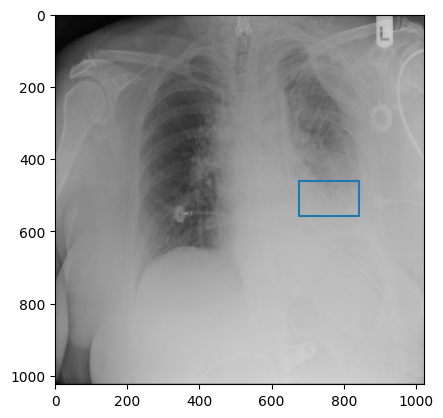

In [7]:
demo_patient_id = val_series.values[8]
demo_img_path = DATASET_DIR + 'images/val/' + demo_patient_id + '.jpg'
demo_label_path = DATASET_DIR + 'labels/val/' + demo_patient_id + '.txt'

plt.imshow(cv2.imread(demo_img_path))

with open(demo_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rx, ry, rw, rh = list(map(float, line.strip().split()))
        
        x, y, w, h = revert_bbox(rx, ry, rw, rh)
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

In [8]:
# %%writefile config.yaml

# path: '/kaggle/working/dataset' # dataset root dir
# train: images/train  # train images (relative to 'path')
# val: images/val  # val images (relative to 'path')

# # Classes
# names:
#   0: pneumonia

In [9]:
# model = YOLO('yolov8l.pt') # yaml
model = YOLO('yolov8s.pt') # yaml

In [10]:
wandb.login(key='da27b138f0f392e3f931cf71acdab08543ac649c')
results = model.train(data='config.yaml', epochs=15,batch=16)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\xiao2\_netrc


Ultralytics YOLOv8.2.91  Python-3.10.14 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=config.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train37, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


wandb: Network error resolved after 0:01:03.016382, resuming normal operation.


AMP: checks passed 


train: Scanning D:\yolov8\yolov8\datasets\labels\train.cache... 5405 images, 545 backgrounds, 0 corrupt: 100%|██████████| 5950/5950 [00:00<?, ?it/s]
val: Scanning D:\yolov8\yolov8\datasets\labels\val.cache... 1502 images, 151 backgrounds, 0 corrupt: 100%|██████████| 1653/1653 [00:00<?, ?it/s]


Plotting labels to runs\detect\train37\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train37
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      4.32G      2.074      2.584       1.99         51        640: 100%|██████████| 372/372 [01:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.89it/s]

                   all       1653       2391      0.295      0.251      0.195     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      4.24G       2.02      2.195      1.934         46        640: 100%|██████████| 372/372 [01:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.82it/s]


                   all       1653       2391      0.398      0.414      0.352      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      4.24G      1.984      2.115      1.881         45        640: 100%|██████████| 372/372 [01:13<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.80it/s]


                   all       1653       2391      0.449      0.427      0.386      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15       4.1G      1.953      2.069      1.861         36        640: 100%|██████████| 372/372 [01:09<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.90it/s]


                   all       1653       2391      0.469      0.486      0.424      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15       4.1G      1.913      2.031      1.818         41        640: 100%|██████████| 372/372 [01:12<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]

                   all       1653       2391      0.427      0.429      0.396      0.138


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15       4.1G      1.994      1.993      1.929         22        640: 100%|██████████| 372/372 [01:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.77it/s]


                   all       1653       2391      0.347      0.407      0.308      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15       4.1G      1.968      1.962      1.931         19        640: 100%|██████████| 372/372 [01:14<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.63it/s]


                   all       1653       2391      0.531      0.506      0.495      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      4.11G      1.942      1.919      1.875         22        640: 100%|██████████| 372/372 [01:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.93it/s]

                   all       1653       2391       0.46       0.47      0.435      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15       4.1G      1.932       1.88      1.859         13        640: 100%|██████████| 372/372 [01:11<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]

                   all       1653       2391      0.465      0.468      0.413      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15       4.1G      1.898      1.835      1.834         23        640: 100%|██████████| 372/372 [01:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.97it/s]

                   all       1653       2391      0.492      0.502      0.474      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15       4.1G      1.882      1.818       1.82         24        640: 100%|██████████| 372/372 [01:11<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1653       2391      0.525      0.544      0.516      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      4.11G      1.879      1.794      1.822         18        640: 100%|██████████| 372/372 [01:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.80it/s]

                   all       1653       2391      0.515      0.482      0.472       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      4.11G      1.855      1.769      1.805         16        640: 100%|██████████| 372/372 [01:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]


                   all       1653       2391      0.516      0.557      0.516      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15       4.1G      1.834      1.746      1.783         17        640: 100%|██████████| 372/372 [01:11<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.91it/s]

                   all       1653       2391      0.529       0.58      0.546      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15       4.1G      1.818      1.707      1.765         18        640: 100%|██████████| 372/372 [01:09<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.83it/s]

                   all       1653       2391      0.517      0.592      0.538      0.222



15 epochs completed in 0.361 hours.
Optimizer stripped from runs\detect\train37\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train37\weights\best.pt, 22.5MB

Validating runs\detect\train37\weights\best.pt...
Ultralytics YOLOv8.2.91  Python-3.10.14 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]


                   all       1653       2391      0.516      0.592      0.537      0.222
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\train37


lr/pg0,▃▆█▇▇▆▆▅▅▄▃▃▂▂▁
lr/pg1,▃▆█▇▇▆▆▅▅▄▃▃▂▂▁
lr/pg2,▃▆█▇▇▆▆▅▅▄▃▃▂▂▁
metrics/mAP50(B),▁▄▅▆▅▃▇▆▅▇▇▇▇██
metrics/mAP50-95(B),▁▃▄▅▄▃▆▅▅▆▇▆▇██
metrics/precision(B),▁▄▆▆▅▃█▆▆▇█████
metrics/recall(B),▁▄▅▆▅▄▆▅▅▆▇▆▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▆▅▄▆▅▄▄▃▃▃▂▁▁


In [11]:
def plot_val_pred(demo_patient_id, verbose=True, split='val'):
    demo_img_path = DATASET_DIR + f'images/{split}/' + demo_patient_id + '.jpg'
    demo_label_path = DATASET_DIR + f'labels/{split}/' + demo_patient_id + '.txt'

    res = model(demo_img_path, verbose=verbose)
    if verbose:
        print(res[0].probs)
        print(res[0].boxes.xywh)

    plt.imshow(cv2.imread(demo_img_path))

    img_size = 1014  
    if os.path.isfile(demo_label_path):
        with open(demo_label_path, "r") as f:
            for line in f:
                if verbose:
                    print(line)
                class_id, rx, ry, rw, rh = list(map(float, line.strip().split()))

                x, y, w, h = revert_bbox(rx, ry, rw, rh)
                plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y], c='blue')

                
    for box in res[0].boxes.xywh.cpu():
        px, py, pw, ph = box
        plt.plot([px-pw/2, px-pw/2, px+pw/2, px+pw/2, px-pw/2], [py-ph/2, py+ph/2, py+ph/2, py-ph/2, py-ph/2], c='orange')

<Figure size 640x480 with 0 Axes>

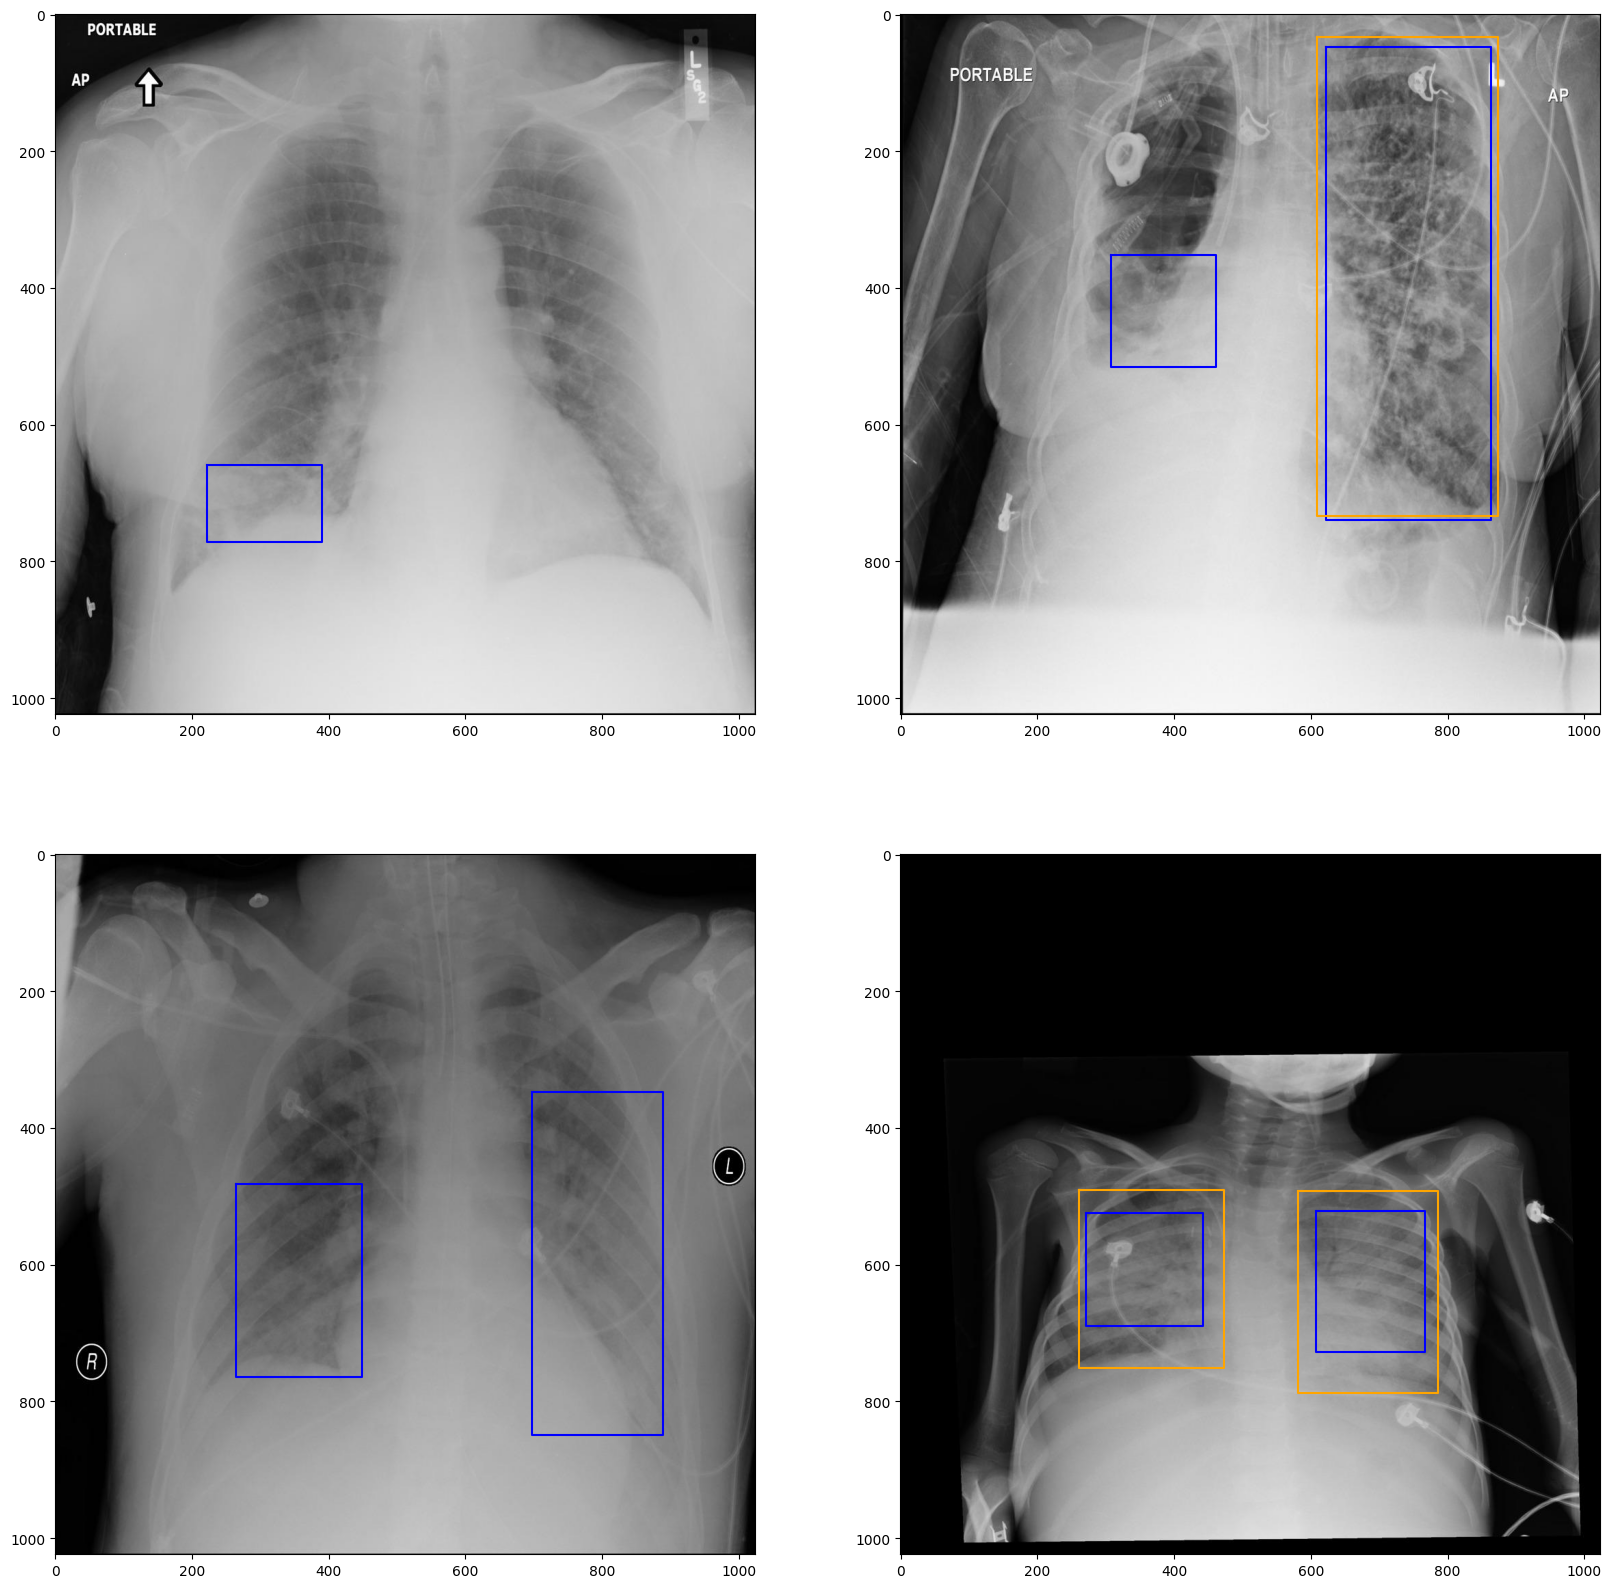

In [12]:
def random_value(series):
    return series.iloc[random.randrange(0, len(series))]

def plot_examples(series, rows = 5, cols = 2, split='val'):
    plt.suptitle(split)
    plt.figure(figsize=(10*cols,10*rows))
    for h in range(rows):
        for w in range(cols):
            plt.subplot(rows, cols, h*2+w+1)
            plot_val_pred(random_value(series), verbose=False, split=split)

plot_examples(train_series, 2, 2, 'train')

<Figure size 640x480 with 0 Axes>

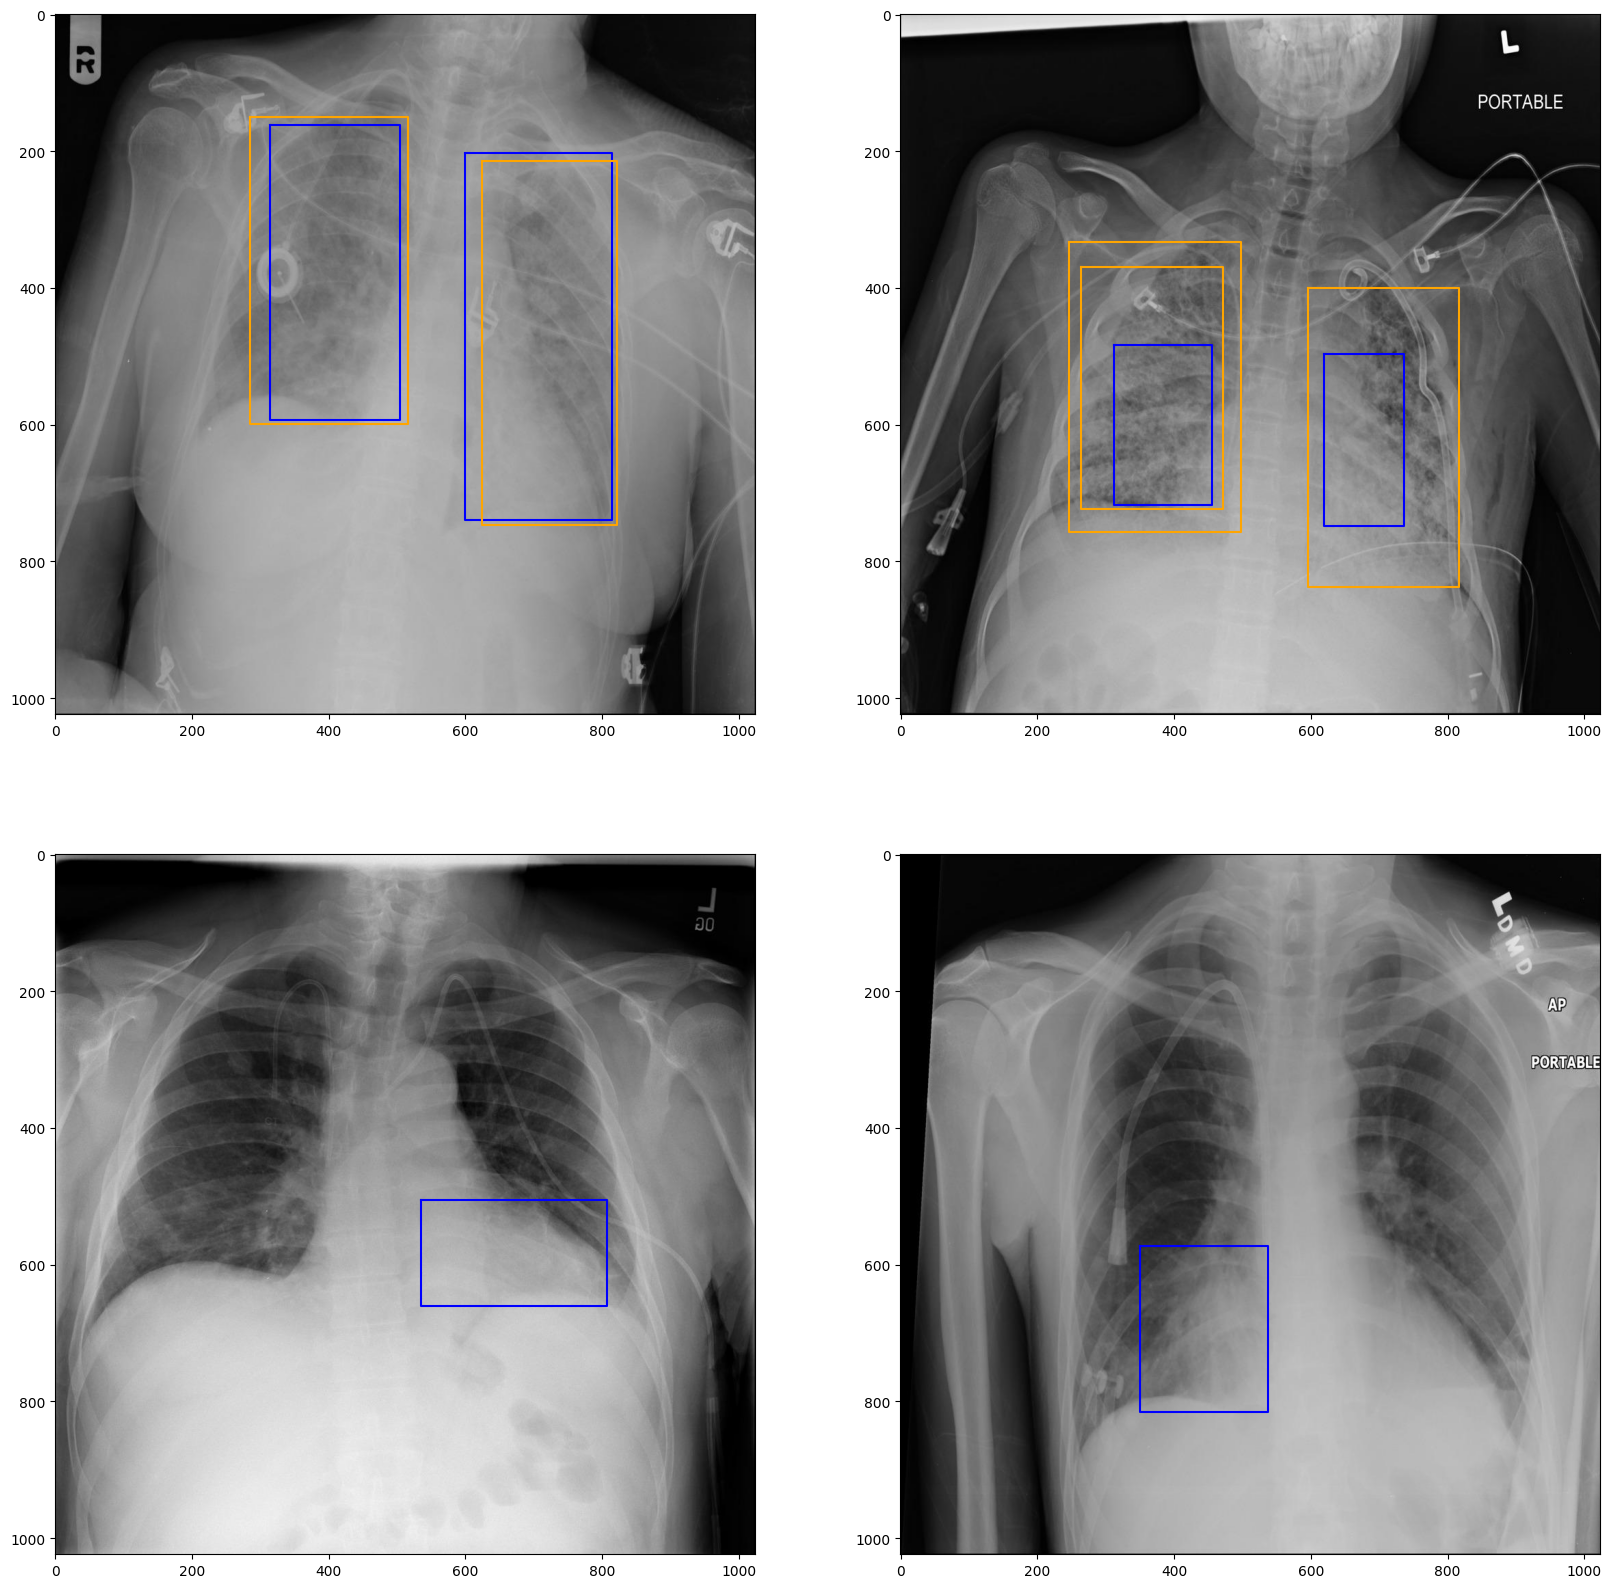

In [13]:
plot_examples(val_series, 2, 2, 'val')

In [14]:
for file in tqdm(os.listdir(TEST_SRC_DIR)):
    src_path = TEST_SRC_DIR + file
    dcm_data = pydicom.dcmread(src_path)
    image_array = dcm_data.pixel_array
    image = Image.fromarray(image_array)
    image.save(TEST_IMG_DIR + os.path.splitext(file)[0] + '.jpg')

100%|██████████| 3000/3000 [00:35<00:00, 84.76it/s]
